# Loading Dataset

In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

Using TensorFlow backend.


In [0]:
import os
print(os.listdir("/content/drive/My Drive/Colab Notebooks/Deep Learning Data"))

['sampleSubmission.csv', 'test1', 'train']


In [0]:
FAST_RUN = False
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

In [0]:
filenames = os.listdir("/content/drive/My Drive/Colab Notebooks/Deep Learning Data/train")
categories = []
for filename in filenames:
  category = filename.split('.')[0]
  if category =='dog':
    categories.append(1)
  else:
    categories.append(0)
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [0]:
df.head()

,filename,category
0,cat.9577.jpg,0
1,cat.9548.jpg,0
2,cat.9574.jpg,0
3,cat.9568.jpg,0
4,cat.9566.jpg,0


In [0]:
df.tail()

,filename,category
24995,dog.1015.jpg,1
24996,dog.10110.jpg,1
24997,dog.10106.jpg,1
24998,dog.1014.jpg,1
24999,dog.10142.jpg,1


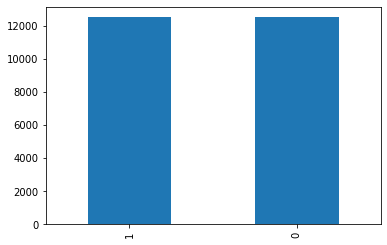

In [0]:
df['category'].value_counts().plot.bar()

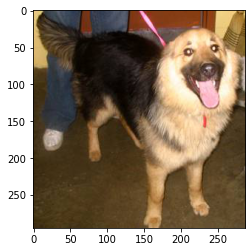

In [0]:
sample = random.choice(filenames)
image = load_img("/content/drive/My Drive/Colab Notebooks/Deep Learning Data/train/"+sample)
plt.imshow(image)

# Model definition

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)       

In [0]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [0]:
earlystop = EarlyStopping(patience=10)


In [0]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [0]:
callbacks = [earlystop, learning_rate_reduction]

In [0]:
df['category'] = df['category'].replace({0: 'cat', 1: 'dog'})

In [0]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

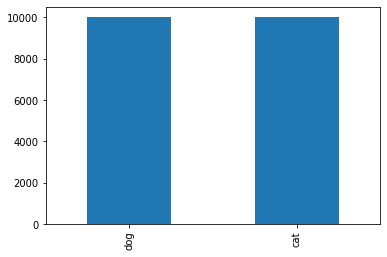

In [0]:
train_df['category'].value_counts().plot.bar()

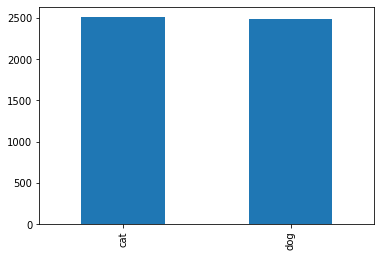

In [0]:
validate_df['category'].value_counts().plot.bar()

# Training Model

In [0]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size = 15

In [0]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
)




In [0]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "/content/drive/My Drive/Colab Notebooks/Deep Learning Data/train/",
    x_col='filename',
    y_col='category', 
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)



Found 20000 validated image filenames belonging to 2 classes.


In [0]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "/content/drive/My Drive/Colab Notebooks/Deep Learning Data/train/",
    x_col='filename',
    y_col='category', 
    target_size=IMAGE_SIZE, 
    class_mode='categorical', 
    batch_size=batch_size
)


Found 5000 validated image filenames belonging to 2 classes.


In [0]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(train_generator, epochs=epochs, validation_data=validation_generator, validation_steps=total_validate//batch_size, steps_per_epoch=total_train//batch_size, callbacks=callbacks)


Epoch 1/50
1333/1333 [==============================] - 8801s 7s/step - loss: 0.7418 - accuracy: 0.6343 - val_loss: 0.5777 - val_accuracy: 0.7131
Epoch 2/50


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1333/1333 [==============================] - 1154s 866ms/step - loss: 0.5491 - accuracy: 0.7264 - val_loss: 0.7361 - val_accuracy: 0.7523
Epoch 3/50
1333/1333 [==============================] - 1161s 871ms/step - loss: 0.4986 - accuracy: 0.7665 - val_loss: 0.6403 - val_accuracy: 0.7077
Epoch 4/50
1333/1333 [==============================] - 1164s 873ms/step - loss: 0.4607 - accuracy: 0.7899 - val_loss: 0.5229 - val_accuracy: 0.7693
Epoch 5/50
1333/1333 [==============================] - 1162s 872ms/step - loss: 0.4273 - accuracy: 0.8059 - val_loss: 0.2864 - val_accuracy: 0.8207
Epoch 6/50
1333/1333 [==============================] - 1163s 872ms/step - loss: 0.4115 - accuracy: 0.8150 - val_loss: 0.2405 - val_accuracy: 0.8193
Epoch 7/50
1333/1333 [==============================] - 1165s 874ms/step - loss: 0.3930 - accuracy: 0.8249 - val_loss: 0.4606 - val_accuracy: 0.8213
Epoch 8/50
1333/1333 [==============================] - 1189s 892ms/step - loss: 0.3876 - accuracy: 0.8310 - val_loss

In [0]:
model.save_weights("model.h5")

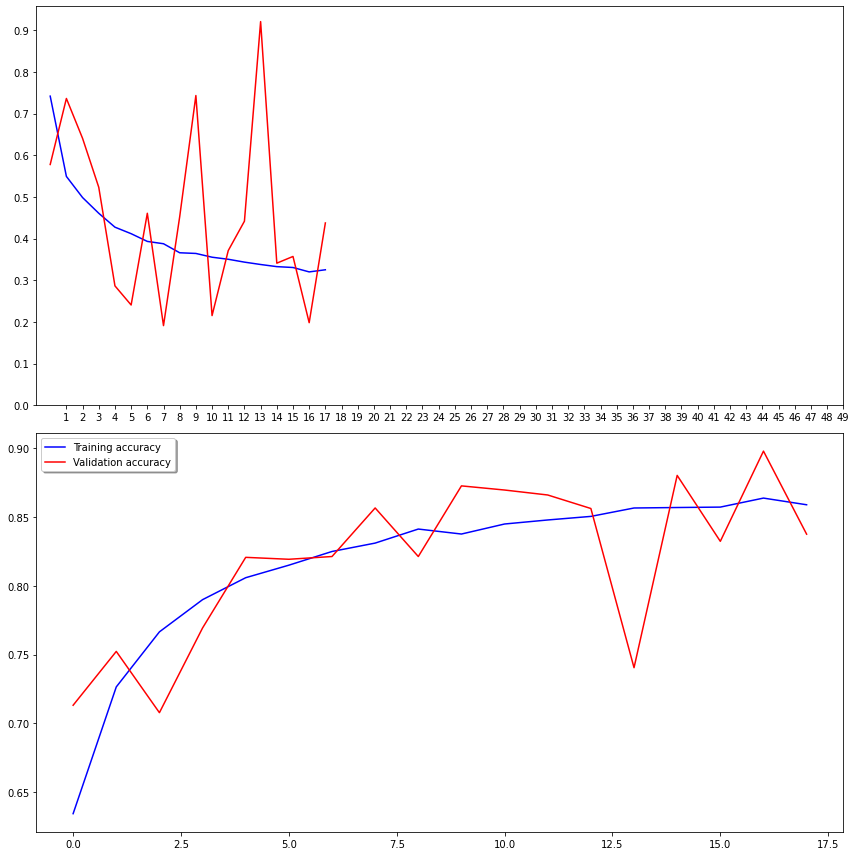

In [0]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
ax1.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()


In [0]:
test_filenames = os.listdir("/content/drive/My Drive/Colab Notebooks/Deep Learning Data/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [0]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    "/content/drive/My Drive/Colab Notebooks/Deep Learning Data/test1/",
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [ ]:
predict=model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [ ]:
import numpy as np
test_df['category'] = np.argmax(predict, axis=-1)

In [0]:
categories = []
for filename in filenames:
  category = filename.split('.')[0]
  if category == 'dog':
    categories.append(1)
    else:
      categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [0]:
test_df['category'].value_counts().plot.bar()


In [0]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12,24))
for index, row in sample_test.iterrows():
  filename = row['filename']
  category = row['category']
  img = load_img("/content/drive/My Drive/Colab Notebooks/Deep Learning Data/test1/"+filename, target_size=IMAGE_SIZE)
  plt.subplot(6, 3, index+1)
  plt.imshow(img)
  plt.xlabel(filename + '(' + "{}".format(category) + ')')
plt.tight_layout()
plt.show()